<a href="https://colab.research.google.com/github/laasyarg/laasyarg/blob/main/Flight_delays_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#GLR65
!pip install dmba

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
#GLR65
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pylab as plt

import dmba
from dmba import classificationSummary, gainsChart

%matplotlib inline

In [ ]:
#GLR65
delays_dfGLR65 = dmba.load_data('FlightDelays.csv')
delays_dfGLR65.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [ ]:
#GLR65
delays_dfGLR65 = dmba.load_data('FlightDelays.csv')

# convert to categorical
delays_dfGLR65.DAY_WEEK = delays_dfGLR65.DAY_WEEK.astype('category')
delays_dfGLR65['Flight Status'] = delays_dfGLR65['Flight Status'].astype('category')

# create hourly bins departure time
delays_dfGLR65.CRS_DEP_TIME = [round(t / 100) for t in delays_dfGLR65.CRS_DEP_TIME]
delays_dfGLR65.CRS_DEP_TIME = delays_dfGLR65.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER']
outcome = 'Flight Status'

X = pd.get_dummies(delays_dfGLR65[predictors])
y = delays_dfGLR65['Flight Status']
classes = list(y.cat.categories)

# split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=1)

# run naive Bayes
delays_nb = MultinomialNB(alpha=0.01)
delays_nb.fit(X_train, y_train)

# predict probabilities
predProb_train = delays_nb.predict_proba(X_train)
predProb_valid = delays_nb.predict_proba(X_valid)

# predict class membership
y_valid_pred = delays_nb.predict(X_valid)
y_train_pred = delays_nb.predict(X_train)


First construct a frequency table and then convert it to the propability table

In [ ]:
#GLR65
# split the original data frame into a train and test using the same random_state
train_dfGLR65, valid_dfGLR65 = train_test_split(delays_dfGLR65, test_size=0.4, random_state=1)

pd.set_option('display.precision', 4)
# probability of flight status
print(train_dfGLR65['Flight Status'].value_counts() / len(train_dfGLR65))
print()

for predictor in predictors:
    # construct the frequency table
    df = train_dfGLR65[['Flight Status', predictor]]
    freqTable = df.pivot_table(index='Flight Status', columns=predictor, aggfunc=len)

    # divide each row by the sum of the row to get conditional probabilities
    propTable = freqTable.apply(lambda x: x / sum(x), axis=1)
    print(propTable)
    print()
pd.reset_option('display.precision')

Flight Status
ontime     0.8023
delayed    0.1977
Name: count, dtype: float64

DAY_WEEK            1       2       3       4       5      6       7
Flight Status                                                       
delayed        0.1916  0.1494  0.1149  0.1264  0.1877  0.069  0.1609
ontime         0.1246  0.1416  0.1445  0.1794  0.1690  0.136  0.1048

CRS_DEP_TIME        6       7       8       9      10      11      12      13  \
Flight Status                                                                   
delayed        0.0345  0.0536  0.0651  0.0192  0.0307  0.0115  0.0498  0.0460   
ontime         0.0623  0.0633  0.0850  0.0567  0.0519  0.0340  0.0661  0.0746   

CRS_DEP_TIME       14      15      16      17      18      19      20      21  
Flight Status                                                                  
delayed        0.0383  0.2031  0.0728  0.1533  0.0192  0.0996  0.0153  0.0881  
ontime         0.0576  0.1171  0.0774  0.1001  0.0349  0.0397  0.0264  0.0529  

In [ ]:
#GLR65
# P(delayed | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA)
P_hat_delayed = 0.0958 * 0.1609 * 0.0307 * 0.4215 * 0.5211 * 0.1977
# P(ontime | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA)
P_hat_ontime = 0.2040 * 0.1048 * 0.0519 * 0.5779 * 0.6478 * 0.8023
print('P_hat_delayed ~ ', P_hat_delayed)
print('P_hat_ontime ~ ', P_hat_ontime)

print('P(delayed|...) = ', P_hat_delayed / (P_hat_delayed + P_hat_ontime))
print('P(ontime|...) = ', P_hat_ontime / (P_hat_delayed + P_hat_ontime))

P_hat_delayed ~  2.0548742506526157e-05
P_hat_ontime ~  0.00033326464123921066
P(delayed|...) =  0.05807791183301656
P(ontime|...) =  0.9419220881669834


In [ ]:
#GLR65
# Subset a specific set
df = pd.concat([pd.DataFrame({'actual': y_valid, 'predicted': y_valid_pred}),
                pd.DataFrame(predProb_valid, index=y_valid.index)], axis=1)
mask = ((X_valid.CARRIER_DL == 1) & (X_valid.DAY_WEEK_7 == 1) & (X_valid.CRS_DEP_TIME_10 == 1) &
        (X_valid.DEST_LGA == 1) & (X_valid.ORIGIN_DCA == 1))

print(df[mask])

      actual predicted         0         1
1225  ontime    ontime  0.057989  0.942011


In [ ]:
#GLR65
classificationSummary(y_train, y_train_pred, class_names=classes)

print()

classificationSummary(y_valid, y_valid_pred, class_names=classes)

Confusion Matrix (Accuracy 0.7955)

        Prediction
 Actual delayed  ontime
delayed      52     209
 ontime      61     998

Confusion Matrix (Accuracy 0.7821)

        Prediction
 Actual delayed  ontime
delayed      26     141
 ontime      51     663


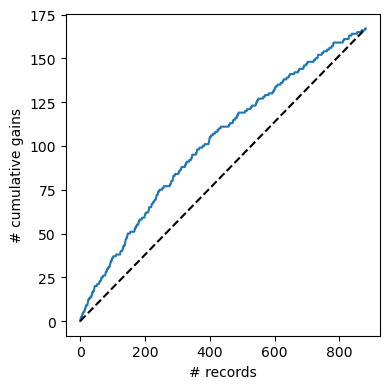

In [ ]:
#GLR65
df = pd.DataFrame({'actual': 1 - y_valid.cat.codes, 'prob': predProb_valid[:, 0]})
df = df.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

fig, ax = plt.subplots()
fig.set_size_inches(4, 4)
gainsChart(df.actual, ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
#GLR65
import numpy as np
np.exp(delays_nb.feature_log_prob_)

array([[0.03831098, 0.02988425, 0.02298965, 0.02528785, 0.03754491,
        0.01379685, 0.03218245, 0.00690226, 0.01073259, 0.01303079,
        0.00383799, 0.00613619, 0.00230586, 0.00996652, 0.00920046,
        0.00766832, 0.04060918, 0.01456292, 0.03065031, 0.00383799,
        0.01992539, 0.00307193, 0.01762719, 0.01609505, 0.10419268,
        0.07967856, 0.07584823, 0.03984311, 0.08427496, 0.01149866,
        0.0628251 , 0.01915932, 0.04443951, 0.00153979, 0.04367344,
        0.00307193, 0.01379685],
       [0.02492933, 0.02832852, 0.02889505, 0.03588229, 0.033805  ,
        0.02719546, 0.0209636 , 0.01246561, 0.01265445, 0.01699787,
        0.01133254, 0.01038832, 0.00680028, 0.01322098, 0.01492058,
        0.01152139, 0.02341857, 0.01548711, 0.02001938, 0.00698912,
        0.00793335, 0.00528953, 0.01057716, 0.01208792, 0.12954902,
        0.05835475, 0.05325596, 0.03116118, 0.11557455, 0.00698912,
        0.04589103, 0.04079224, 0.02341857, 0.00207917, 0.033805  ,
        0.00340

<span style="color:red">
Solve Problem 8.2 on page 215 of your textbook.
</span>

a.To predict if an accident just reported will purely depend on the involvement of the injury, and data reports in the system.

In [ ]:
#GLR65
import pandas as pd

accidents_dfGLR65 = dmba.load_data ('accidentsFull.csv')
accidents_dfGLR65.head()

# Create a dummy variable 'INJURY' based on 'MAX_SEV_IR'
accidents_df['INJURY'] = accidents_df['MAX_SEV_IR'].apply(lambda x: 'Yes' if x in [1, 2] else 'No')

# Count occurrences of 'INJURY' values
injury_counts = accidents_df['INJURY'].value_counts()

# Determine the prediction based on the counts
prediction = 'Yes' if injury_counts['Yes'] > injury_counts['No'] else 'No'

print("Prediction based on available data:", prediction)


Prediction based on available data: Yes


b. selecting first 12 records in the dataset

In [ ]:
#GLR65
import pandas as pd

# Assuming the data is loaded into a DataFrame named accidents_df

# Selecting the first 12 records and relevant columns
subset_df = accidents_df[['WEATHER_R', 'TRAF_CON_R', 'INJURY']].head(12)

# Creating a pivot table
pivot_table = pd.pivot_table(subset_df, values=None, index=['WEATHER_R', 'TRAF_CON_R'], columns=['INJURY'], aggfunc='size', fill_value=0)

print("Pivot table:")
print(pivot_table)

# Compute the exact Bayes conditional probabilities
exact_bayes_probabilities = pivot_table.div(pivot_table.sum(axis=1), axis=0)
print("\nExact Bayes conditional probabilities:")
print(exact_bayes_probabilities)

# Manually compute the naive Bayes conditional probability for a specific combination
# Let's take WEATHER_R = 1 and TRAF_CON_R = 1
specific_combination = (1, 1)
naive_bayes_probability = pivot_table.loc[specific_combination, 'Yes'] / pivot_table.loc[specific_combination].sum()
print("\nNaive Bayes conditional probability for WEATHER_R = 1 and TRAF_CON_R = 1:", naive_bayes_probability)


Pivot table:
INJURY                No  Yes
WEATHER_R TRAF_CON_R         
1         0            1    2
          1            1    0
          2            1    0
2         0            5    1
          1            1    0

Exact Bayes conditional probabilities:
INJURY                      No       Yes
WEATHER_R TRAF_CON_R                    
1         0           0.333333  0.666667
          1           1.000000  0.000000
          2           1.000000  0.000000
2         0           0.833333  0.166667
          1           1.000000  0.000000

Naive Bayes conditional probability for WEATHER_R = 1 and TRAF_CON_R = 1: 0.0


c. i.  Based on the information provided, predictors that can be included in the analysis without information or initial reports about the accident itself are:
- Location characteristics
- Traffic situations
- Weather conditions

ii. Running naive bayes classifier

In [ ]:
#GLR65
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import confusion_matrix


X = accidents_dfGLR65[['WEATHER_R', 'TRAF_CON_R']]
y = accidents_df['INJURY']

# Split the data into training and validation sets (60% training, 40% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize and train the naive Bayes classifier
nb_classifier = CategoricalNB()
nb_classifier.fit(X_train, y_train)

# Predict on the validation set
y_pred = nb_classifier.predict(X_val)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion matrix:")
print(conf_matrix)



Confusion matrix:
[[1290 6983]
 [1107 7494]]


iii. The overall error for the validation set is obtained by comparing predicted values with real values in response of variable      through which confusion matrix is generated.

iv. The total error for the validation set can be estimated by adding the number of false positives and false negatives and dividing by the total number of observations.

v. We get a probability of zero, as there might not be any instances in the data set where accidents occur with a specific speed limit,  and no injury